# Semantic Segmentation of World View Imagery Using Mask RCNN

The following notebook performs object detection and segmentation of satellite imagery, particularly very high-resolution World View data. The notebook outlines every step of the pipeline which is controlled by general configuration variables in the variables section and some configuration files.

Author: Jordan A. Caraballo-Vega - NASA GSFC, <jordan.a.caraballo-vega@nasa.gov>  
Release Date: 07/23/2021  
Version: 2021.10

## 1. Usage and installation requirements

### 1.1 Creating a conda environment (One time only)

In order to run this notebook you will need a conda environment with all dependencies installed. ADAPT provides a built-in environment from the JupyterHub interface that is only missing a couple of packages that can be installed on the fly. In order to get started quickly, follow the next steps:

1. Login to adaptlogin.nccs.nasa.gov
2. Load the Anaconda module

```bash
module load anaconda3
```

3. Clone the existing environment

```bash
conda create --name slump-detection-11.1 --clone /att/nobackup/jacaraba/.conda/envs/slump-detection-11.1
```

Now you are ready to move on to JupyterHub.


### 1.2 Login to ADAPT JupyterHub

To leverage NCCS ADAPT resources, you will need to login to ADAPT JupyterHub. The steps are outlined below.

1. Login to the NCCS JupyterHub https://www-proxy-dev.nccs.nasa.gov/jupyterhub-prism/.
2. Open this notebook via the file/upload method. Also upload the core and config folders
3. Select kernel, in this case "conda-slump-detection-11.1".
4. Start working on your notebook.

## 2. Define global variables for the CNN pipeline

In [1]:
# !install ipykernel
# #!module load anaconda
# !echo $PATH
# #!source ~/.bashrc
# !echo $PATH

### 2.1 Import Python Libraries

In this section we include all Python libraries required to execute the code below. There are no external code dependencies besides the packages installed under section 1.1.

In [23]:
import os
import glob
import time
import torch
import numpy as np
import imageio

In [3]:
# !. "/att/gpfsfs/home/appmgr/app/anaconda/platform/x86_64/centos/7/3-2020.07/etc/profile.d/conda.sh"
# !conda install anaconda-navigator 
#!conda activate slump-detection-11.1

In [4]:
import cv2
import xarray as xr
import rioxarray as rxr
from skimage.util import img_as_ubyte
from skimage import exposure
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
CONFIG = 'config/slump_mask_rcnn_R_50_FPN_3x.yaml'
PREPROCESS = False
VIS = True
TRAIN = True
PREDICT = True

In [6]:
#!pip install h5py
import h5py

In [7]:
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances

In [8]:
from core.utils import arg_parser, get_bands, gen_data_png, gen_coco_dataset
from core.utils import predict_batch, arr_to_tif

In [9]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(22)

### 2.2 Read configuration file

In [46]:
cfg = get_cfg()  # get default configurations in place
print('------------')
print('cfg: ')
#print(cfg)
#print('------------')
cfg.set_new_allowed(True)  # allow for new configuration objects
cfg.INPUT.MIN_SIZE_TRAIN = 256  # small hack to allow merging new fields
cfg.merge_from_file(CONFIG)  # merge from file

------------
cfg: 


## 3. Preprocessing

Extract dataset tiles from label and imagery rasters.

### 3.1 Generate Dataset

In [11]:
percentile = 2

trainingFilesPath = '/att/nobackup/nmemarsa/RST_Data/sims/ML/seg_train/*.h5'
filenames = glob.glob(trainingFilesPath)
counter = len(filenames)
print('total number of filenames are: ', counter)

total number of filenames are:  100


In [12]:
#print(filenames)

In [13]:
def convert(img, target_min, target_max, target_type):
    """ Coerce an image to a given type, with values within a given range """ 
    
    min_v = img.min()
    max_v = img.max()

    a = (target_max - target_min) / (max_v - min_v)
    new_img = a*(img - min_v) + target_min
    new_img = new_img.astype(target_type)
    return new_img

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
        
if PREPROCESS:
    for filename in filenames:

        print('filename is: ',filename)
        file = h5py.File(filename,'r')
        root_items = list(file.items())
        num_groups = len(root_items)
        print('Number of items/groups: ', num_groups)
        print('Items in root directory: ', root_items)

        i = num_groups - 1

        #for i in range(num_groups):
        if i < 10:
            dir_name = 'Frame_000'+str(i+1)+'/'
            #print('dir_name: '+dir_name)
        elif i < 100:
            dir_name = 'Frame_00'+str(i+1)+'/'
            #print('dir_name: '+dir_name)
        elif i < 1000:
            dir_name = 'Frame_0'+str(i+1)+'/'
            #print('dir_name: '+dir_name)
        else:
            dir_name = 'Frame_'+str(i+1)+'/'
            #print('dir_name: '+dir_name)



        # get and display test data
        image_data = file.get(dir_name +  'ActualFrame')
        image_data = np.array(image_data)
        # scale data to -1  and 1
        print ('orig min, max image: ')
        print(image_data.min())
        print(image_data.max())
        image_data = convert(image_data, -1, 1, np.float32)

      

        label_data = file.get(dir_name +  'CosmicRays')
        label_data= np.array(label_data)
        
        #lower resolution here, and then make 3d for png format
        image_data = exposure.rescale_intensity(img_as_ubyte(image_data))
        print ('scaled min, max image: ')
        print(image_data.min())
        print(image_data.max())
        image = []
        print(range(3))
        for k in range(3):
         image.append(image_data)
        image = np.array(image)
        image = image.astype('uint8')
        print('image shape 1: ')
        print(np.shape(image))
        image = np.reshape(image,(4096,4096,3))
        print('image shape 2: ')
        print(np.shape(image))

        # transforming 1 to 255 for now to visualize locally
        label_data[label_data == 1] = 255
        label_data = label_data.astype('uint8')

        # extract tiles from the imagery and generate masks
        # make png like image
        
       
       
        for set in ['TRAIN', 'TEST', 'VAL']:
            print(set)
            gen_data_png(filename, image, label_data, cfg, set=set)
            gen_coco_dataset(cfg, set=set, img_reg='*_img_*.png', label_reg='*_lbl_*.png')


In [15]:
# if PREPROCESS:
#     # Process each image individually
#     for image, label in zip(cfg.DATASETS.IMAGES, cfg.DATASETS.LABELS):

#         # read input data
#         image_data = rxr.open_rasterio(image).transpose("y", "x", "band")
#         label_data = rxr.open_rasterio(label).squeeze().values.astype(np.uint8)
#         print("Image and label shapes: ", image_data.shape, label_data.shape)

#         # drop bands we are not interested in given the ones we actually want
#         image_data = get_bands(
#             image_data, cfg.INPUT.INPUT_BANDS, cfg.INPUT.OUTPUT_BANDS
#         ).values.astype(np.int16)
#         print("Image after get_bands: ", image_data.shape, label_data.shape)

#         # EVHR outputs values outside of allowed range [0,10000]
#         image_data = np.clip(image_data, 0, 10000)

#         # lower resolution here
#         image_data = exposure.rescale_intensity(img_as_ubyte(image_data))

#         # transforming 1 to 255 for now to visualize locally
#         label_data[label_data == 1] = 255

#         # extract tiles from the imagery and generate masks
#         for set in ['TRAIN', 'TEST', 'VAL']:
#             gen_data_png(image, image_data, label_data, cfg, set=set)
#             gen_coco_dataset(
#                 cfg, set=set, img_reg='*_img_*.png', label_reg='*_lbl_*.png'
#             )

### 3.2 Visualize some training tiles

Lets visualize some training tiles.

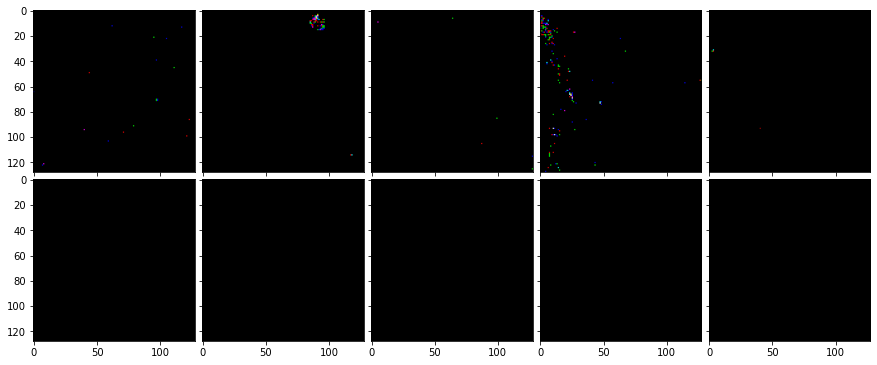

In [16]:
if VIS:

    vis_dir = os.path.join(cfg.DATASETS.OUTPUT_DIRECTORY, 'TRAIN')
    images = sorted(glob.glob(os.path.join(vis_dir, '*_img_*.png')))[:5]
    labels = sorted(glob.glob(os.path.join(vis_dir, '*_lbl_*.png')))[:5]

    fig = plt.figure(figsize=(15, 15))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im_id in zip(grid, images + labels):
        #print(ax, im_id)
        # Iterating over the grid returns the Axes.
        ax.imshow(cv2.imread(im_id))

    plt.show()

## 4. Train

Train model using detectron2 framework.

In [17]:
if TRAIN:
    # Path and directory configurations
    input_dir = cfg.DATASETS.OUTPUT_DIRECTORY
    print('input_dir')
    print(input_dir)
    cfg.OUTPUT_DIR = cfg.MODEL.OUTPUT_DIRECTORY
    print(cfg.OUTPUT_DIR)
    dataset_name = cfg.DATASETS.COCO_METADATA.DESCRIPTION
    print(dataset_name)

    # Registor COCO datasets for train, val, and test
    for curType in ['TRAIN', 'VAL', 'TEST']:
        curJson = os.path.join(
            input_dir, dataset_name + '_' + curType + '.json'
        )
        curDir = os.path.join(input_dir, curType)
        register_coco_instances(f'{dataset_name}_{curType}', {}, curJson, curDir)

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    finalModelPath = os.path.join(cfg.OUTPUT_DIR, cfg.MODEL.MODEL_NAME)
    print('final model path:')
    print(finalModelPath)
    print('delete mode?')
    print(cfg.MODEL.DELETE_MODEL)

    if os.path.isfile(finalModelPath) and cfg.MODEL.DELETE_MODEL:
        os.remove(finalModelPath)
        print("WARNING: deleted existing model, re-training")

    if not os.path.isfile(finalModelPath):  # no re-run training unless cleared
        trainer = DefaultTrainer(cfg)
        trainer.resume_or_load(resume=False)
        trainer.train()

input_dir
/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data
/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/model_output
rst-detection_trialrun
final model path:
/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/model_output/model_final.pth
delete mode?
True
[02/04 10:47:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), str

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[02/04 10:47:32 d2.engine.train_loop]: Starting training from iteration 0
[02/04 10:47:47 d2.utils.events]:  eta: 0:01:04  iter: 19  total_loss: 2.321  loss_cls: 0.2213  loss_box_reg: 0.0009018  loss_mask: 0.669  loss_rpn_cls: 0.6862  loss_rpn_loc: 0.713  time: 0.2327  data_time: 0.0879  lr: 8.0338e-05  max_mem: 997M
[02/04 10:47:51 d2.utils.events]:  eta: 0:00:58  iter: 39  total_loss: 1.62  loss_cls: 0.06835  loss_box_reg: 0.0004839  loss_mask: 0.3237  loss_rpn_cls: 0.6098  loss_rpn_loc: 0.5889  time: 0.2285  data_time: 0.0412  lr: 0.00016359  max_mem: 997M
[02/04 10:47:56 d2.utils.events]:  eta: 0:00:54  iter: 59  total_loss: 0.8813  loss_cls: 0.1127  loss_box_reg: 0.02032  loss_mask: 0.01958  loss_rpn_cls: 0.4573  loss_rpn_loc: 0.2483  time: 0.2327  data_time: 0.0408  lr: 0.00024684  max_mem: 1123M
[02/04 10:48:01 d2.utils.events]:  eta: 0:00:50  iter: 79  total_loss: 0.6707  loss_cls: 0.07673  loss_box_reg: 0.09738  loss_mask: 0.00447  loss_rpn_cls: 0.3761  loss_rpn_loc: 0.1212  t

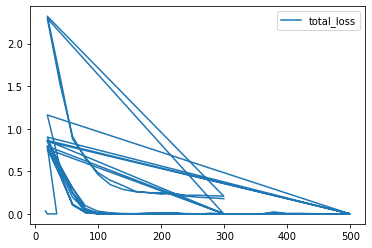

In [18]:
# plot loss

import json
import matplotlib.pyplot as plt

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(cfg.MODEL.OUTPUT_DIRECTORY + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
# plt.plot(
#     [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
#     [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss'], loc='upper right')
plt.show()


## 5. Predict

Classify the images fed in raster format.

In [47]:
if PREDICT:
    # Path and directory configurations
    cfg.OUTPUT_DIR = cfg.MODEL.OUTPUT_DIRECTORY
    print(cfg.OUTPUT_DIR)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    # setting up model information
    model_weights = os.path.join(cfg.OUTPUT_DIR, cfg.MODEL.MODEL_NAME)
    cfg.MODEL.WEIGHTS = model_weights

    # build model and model metadata
    model = build_model(cfg)  # build architecture and maps
    model_dict = torch.load(model_weights, map_location=torch.device('cpu'))
    model.load_state_dict(model_dict['model'])  # load metadata

    # TODO: In a later version, parellize the model over several GPUs.
    # import torch.nn as nn
    # model = nn.DataParallel(model)
    model.train(False)  # we are predicting, weights are already updated

    # Get list of files to predict
    print(cfg.PREDICTOR)
    if isinstance(cfg.PREDICTOR.PRED_FILENAMES, str):
        cfg.PREDICTOR.PRED_FILENAMES = glob.glob(cfg.PREDICTOR.PRED_FILENAMES)
    print(cfg.PREDICTOR.PRED_FILENAMES)
    print(f'Number of files to predict: {len(cfg.PREDICTOR.PRED_FILENAMES)}')

    # Tterate over files and predict them
    #cfg.PREDICTOR.PRED_FILENAMES = ['/att/nobackup/ewebb5/5-toas/WV02_20160709_M1BS_10300100591D6600-toa_pansharpen.tif']
    for fname in cfg.PREDICTOR.PRED_FILENAMES:
        print('============')
        print(fname)
        # measure execution time
        start_time = time.perf_counter()

        # path + name to store prediction into
        save_image = \
            cfg.OUTPUT_DIR + '/' + fname[:-4].split('/')[-1] + '_pred.tif'

        # --------------------------------------------------------------------------------
        # if prediction is not on directory, start predicting
        # (allows for restarting script if it was interrupted at some point)
        # --------------------------------------------------------------------------------
        # if not os.path.isfile(save_image):

        print(f'Starting to predict {fname}')
        # --------------------------------------------------------------------------------
        # Extracting and resizing test and validation data
        # --------------------------------------------------------------------------------
        x_data = xr.open_rasterio(fname, chunks=dict(cfg.DATALOADER.DASK_SIZE))
        x_data = get_bands(x_data, cfg.INPUT.INPUT_BANDS, cfg.INPUT.OUTPUT_BANDS)
      
        # --------------------------------------------------------------------------------
        # Calculate missing indices
        # --------------------------------------------------------------------------------

        # --------------------------------------------------------------------------------
        # Getting predicted labels
        # --------------------------------------------------------------------------------
        prediction = predict_batch(x_data=x_data, model=model, config=cfg)
        prediction[prediction > 1] = 1
        #prediction = exposure.rescale_intensity(img_as_ubyte(prediction))
        print('shape of prediction: ', np.shape(prediction))

        # --------------------------------------------------------------------------------
        # Generating visualization from prediction
        # --------------------------------------------------------------------------------
        print(f'Saved image {save_image}.')
        print('fname: ')
        print(fname)
        #save prediction as .tiff
        
        
        imageio.imwrite(save_image, prediction)
        
        print('sum prediction: ', sum(sum(prediction)))
        
        #arr_to_tif(raster_f=fname, segments=prediction, out_tif=save_image)
        #arr_to_tif(fname, prediction, save_image)
        
        #del prediction

        # This is the case where the prediction was already saved
        # else:
        #    print(f'{save_image} already predicted.')

        print(f'Time: {(time.perf_counter() - start_time)}')

/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/model_output
PRED_FILENAMES: ['/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/TEST/test_white80_300sec_cr_1_solutio_img_2.png']
PRED_WINDOW_SIZE: [128, 128]
VALI_FILENAMES: ['/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/TEST/test_white80_300sec_cr_1_solutio_lbl_2.png']
['/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/TEST/test_white80_300sec_cr_1_solutio_img_2.png']
Number of files to predict: 1
/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/TEST/test_white80_300sec_cr_1_solutio_img_2.png
Starting to predict /att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/TEST/test_white80_300sec_cr_1_solutio_img_2.png
wsize: 128x128. Prediction shape: (128, 128)


  0%|          | 0/1 [00:00<?, ?it/s]

shape of prediction:  (128, 128)
Saved image /att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/model_output/test_white80_300sec_cr_1_solutio_img_2_pred.tif.
fname: 
/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/TEST/test_white80_300sec_cr_1_solutio_img_2.png
sum prediction:  0.0
Time: 0.10736160911619663


In [48]:
# get validation data
for fname in cfg.PREDICTOR.VALI_FILENAMES:
    print(fname)
    img_labels = imageio.imread(fname)
    print('size labels: ', img_labels.shape)
    print('sum labels: ', sum(sum(img_labels)))



/att/nobackup/nmemarsa/PythonCode/nasa-ai-quickstart/notebooks/mask-rcnn/rst_maskrcn_data/TEST/test_white80_300sec_cr_1_solutio_lbl_2.png
sum labels:  0


In [20]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

NameError: name 'DefaultPredictor' is not defined

In [ ]:
from detectron2.utils.visualizer import ColorMode

#dataset_dicts = get_balloon_dicts("balloon/val")
#for d in random.sample(dataset_dicts, 3):    
#    im = cv2.imread(d["file_name"])
#    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
#    v = Visualizer(im[:, :, ::-1],
#                   metadata=balloon_metadata, 
#                   scale=0.5, 
#                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
#    )
#    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#    cv2_imshow(out.get_image()[:, :, ::-1])